In [ ]:
from pathlib import Path
import os

# 1. Define the base path relative to the notebook's location
# Path.cwd() returns the current working directory (where the notebook is)
BASE_DIR = Path.cwd()

# 2. Define paths for your specific data folders
DATA_DIR = BASE_DIR / "data"
RAW_DIR = DATA_DIR / "raw"
FILTERED_DIR = DATA_DIR / "filtered"
MODELS_DIR = DATA_DIR / "models"

# 3. (Optional but recommended) Automatically create output folders if they don't exist
# This prevents errors if a teammate clones the repo but hasn't run the filtering scripts yet.
FILTERED_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Working with data in: {DATA_DIR}")

# 2. CONTENT NETWORK

### Importations

In [ ]:
import pandas as pd
import plotly.graph_objects as go
import os
import numpy as np
import json

Note: All graphs are saved in JSON files so that they can be easily integrated into the website...

## 2.1. Data Loading & Preprocessing

Before building the network, we must separate the signal from the noise. Raw YouTube comments are often filled with spam, bots, and "drive-by" users. To ensure our network reflects genuine human engagement, we apply a **High-Fidelity Filter** to isolate **"Super Users."**

**Filtering Criteria:**
* **User Consistency:** Must have commented on at least **24 unique videos**.
* **Social Validation:** Must have received at least **5 total likes** on their comments.
* **Bot Removal:** We explicitly remove the top **1% of most active accounts** to strip out automated scripts.
* **Video Quality:** We only considered "high interaction" videos with at least **200 unique authors**, ensuring the video sparked a real community discussion.

*The code below loads the raw data and applies these filters to generate our clean `df_super_users`.*

## 2.2. Network Construction

We now aggregate the individual user interactions into a global map of the ecosystem.
* **Nodes:** YouTube Channels (Aggregated by Category + Channel Name).
* **Edges:** Formed when users comment on *both* channels.

### 2.2.1 Calculating the Interaction Score
To avoid a map dominated by massive channels simply due to their size, we calculate a custom **Interaction Score** for every pair of channels. This metric balances **specificity** (how unique is the link?) with **volume** (how many people share it?).

$$\text{Score}_{ij} = \text{PMI}(i, j) \times \log(\text{Shared Users}_{ij})$$

*The code below aggregates the user data into channel pairs and calculates this score.*

## 2.3. Global Visual Analysis

Before analyzing specific clusters, we visualize the composition and connectivity distribution of the entire network.

### 2.3.1. Network Composition (Sunburst Diagram)
To understand the hierarchy of our nodes, we visualize the dataset composition using a **Sunburst Diagram**. This displays the proportion of channels contained within each high-level category, giving us a view of the network's density and scale before we inspect the edges.

*The code below prepares the hierarchical data (Category $\to$ Channel) for the Sunburst visualization. We use 'group_network_edges_pmi_1.0_shared_3_inter_channel.csv' as input for the network informations. The code generates a 'sunburst_plot.json' file to facilate integration to website*

In [ ]:
# --- 1. CONFIGURATION ---
file_path = FILTERED_DIR / "group_network_edges_pmi_1.0_shared_3_inter_channel.csv"
output_path = MODELS_DIR / "sunburst_plot.json"

# Colors definition
COLOR_INTERNAL = "#B0BEC5"
COLOR_EXTERNAL = "#FFCCBC" 

CATEGORY_PALETTE = {
    'Entertainment': '#FF3B30',       
    'Comedy': '#FFD60A',              
    'People & Blogs': '#FF9F0A',      
    'Sports': '#30D158',              
    'Music': '#0A84FF',               
    'Gaming': '#BF5AF2',              
    'Howto & Style': '#FF375F',       
    'Film & Animation': '#AC8E68',    
    'Science & Technology': '#64D2FF',
    'News & Politics': '#8E8E93',     
    'Education': '#5E5CE6',           
    'Pets & Animals': '#D2691E',      
    'Autos & Vehicles': '#00D1D1',    
    'Travel & Events': '#E0AAFF',     
    'Nonprofits & Activism': '#95A5A6'
}

DEFAULT_COLOR = "#333333"

def generate_sunburst_json():
    print("Generating Sunburst Data...")

    # --- 2. LOAD & PREPARE DATA ---
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return

    # Helper: Extract category name
    def get_cat(s):
        return s.split('|')[0] if pd.notna(s) else "Unknown"

    df['Cat1'] = df['group1'].apply(get_cat)
    df['Cat2'] = df['group2'].apply(get_cat)

    # Aggregate Volume (Shared Users)
    agg_df = df.groupby(['Cat1', 'Cat2'])['shared_commentators'].sum().reset_index()

    # Filter: Remove noise (Bottom 20%) to keep chart clean
    threshold = agg_df['shared_commentators'].quantile(0.20)
    agg_filtered = agg_df[agg_df['shared_commentators'] > threshold].copy()

    # --- 3. BUILD HIERARCHY (Tree Structure) ---
    tree = {}

    def insert_data(center, neighbor, vol):
        if center not in tree: tree[center] = {'Internal': {}, 'External': {}}
        
        type_label = 'Internal' if center == neighbor else 'External'
        
        # Add to the specific branch
        if neighbor in tree[center][type_label]:
            tree[center][type_label][neighbor] += vol
        else:
            tree[center][type_label][neighbor] = vol

    # Populate Tree (Symmetric)
    for _, row in agg_filtered.iterrows():
        c1, c2, vol = row['Cat1'], row['Cat2'], row['shared_commentators']
        insert_data(c1, c2, vol)
        if c1 != c2: insert_data(c2, c1, vol)

    # --- 4. FLATTEN TO PLOTLY LISTS ---
    ids = []
    labels = []
    parents = []
    values = []
    node_colors = []

    for center, branches in tree.items():
        # Calculate Branch Totals
        internal_sum = sum(branches['Internal'].values())
        external_sum = sum(branches['External'].values())
        center_total = internal_sum + external_sum
        
        if center_total == 0: continue

        # LEVEL 0: CENTER (The Category)
        ids.append(center)
        labels.append(center)
        parents.append("")
        values.append(center_total)
        node_colors.append(CATEGORY_PALETTE.get(center, DEFAULT_COLOR))

        # LEVEL 1: TYPE (Internal vs External)
        for type_label, neighbors in branches.items():
            branch_sum = sum(neighbors.values())
            
            if branch_sum > 0:
                branch_id = f"{center} - {type_label}"
                
                ids.append(branch_id)
                labels.append(type_label)
                parents.append(center)
                values.append(branch_sum)
                
                if type_label == 'Internal':
                    node_colors.append(COLOR_INTERNAL)
                else:
                    node_colors.append(COLOR_EXTERNAL)

                # LEVEL 2: LEAVES (Connected Categories)
                for neighbor, vol in neighbors.items():
                    leaf_id = f"{branch_id} - {neighbor}"
                    
                    ids.append(leaf_id)
                    labels.append(neighbor)
                    parents.append(branch_id)
                    values.append(vol)
                    
                    node_colors.append(CATEGORY_PALETTE.get(neighbor, DEFAULT_COLOR))

    # --- 5. GENERATE FIGURE OBJECT ---
    fig = go.Figure(go.Sunburst(
        ids=ids,
        labels=labels,
        parents=parents,
        values=values,
        marker=dict(colors=node_colors),
        branchvalues="total",
        
        # DISPLAY: Label + Percentage of Parent Ring
        textinfo="label+percent parent",
        
        # HOVER INFO
        hovertemplate='<b>%{label}</b><br>Volume: %{value:,.0f}<br>Share: %{percentParent:.1%}<extra></extra>'
    ))

    fig.update_layout(
        margin=dict(t=40, l=0, r=0, b=0),
        width=1000,
        height=1000,
        font=dict(family="Arial", size=14)
    )

    
    fig.write_json(output_path)
    
    print(f"Saved JSON data! Open '{output_path}' to use it.")

# Main
if __name__ == "__main__":
    generate_sunburst_json()

## Chord Diagram
We create a chord diagram to visualize inter-connectivity and flow between distinct categories.

 Therefore, this part reads prepare the data. Then, we upload the CSV obtained onto 'flourish' manually...

### 2.3.2. Connection Strength (Violin Plots)
We analyze the distribution of **Interaction Scores** across the dataset. The Violin Plot below reveals the density of connection strengths: wide sections indicate a high frequency of connections at that specific score intensity. This helps us understand if the network is dominated by weak links or strong, engaged ties.

*The code below generates Violin Plots to show the density of edge weights per category. We use 'group_network_edges_pmi_1.0_shared_3_inter_channel.csv' as input for the network informations. The code generates a 'violin_graph.json' file to facilate integration to website***

In [ ]:
# --- 1. CONFIGURATION ---
file_path = FILTERED_DIR / "group_network_edges_pmi_1.0_shared_3_inter_channel.csv"
output_path = MODELS_DIR / "violin_graph.json"

def generate_violin_json():
    print("Generating Violin Chart Data...")

    # --- 2. LOAD DATA ---
    if not os.path.exists(file_path):
        print(f"Error: File '{file_path}' not found.")
        return

    df = pd.read_csv(file_path)
    if df.empty:
        print("Warning: Input dataframe is empty.")
        return

    # --- 3. PREPROCESS DATA ---
    # Prepare two sides of edges to get full node stats
    df_1 = df[['group1', 'group1_size', 'score']].rename(columns={'group1': 'Node', 'group1_size': 'Size', 'score': 'Edge_Score'})
    df_2 = df[['group2', 'group2_size', 'score']].rename(columns={'group2': 'Node', 'group2_size': 'Size', 'score': 'Edge_Score'})
    all_nodes = pd.concat([df_1, df_2])

    # Aggregate stats per node
    node_stats = all_nodes.groupby('Node').agg(
        Size=('Size', 'mean'), 
        Degree=('Edge_Score', 'count'), 
        Avg_Score=('Edge_Score', 'mean')
    ).reset_index()

    # Create Categories & Log metrics
    def get_category(s):
        return s.split('|')[0] if pd.notna(s) else "Unknown"

    node_stats['Category'] = node_stats['Node'].apply(get_category)
    node_stats['Log_Size'] = np.log10(node_stats['Size'] + 1)
    node_stats['Log_Degree'] = np.log10(node_stats['Degree'] + 1)
    node_stats['Log_Score'] = np.log10(node_stats['Avg_Score'] + 1)

    # Filter: Keep only top 15 categories
    top_cats = node_stats['Category'].value_counts().nlargest(15).index
    data = node_stats[node_stats['Category'].isin(top_cats)].copy()
    data.sort_values('Category', inplace=True)
    categories = data['Category'].unique()

    # --- 4. HTML TOOLTIP GENERATOR ---
    def generate_table_html(cat_name, series_data):
        stats = series_data.describe()
        html = f"""
        <span style='font-size:14px; font-weight:bold;'>{cat_name}</span><br>
        <table style="border: 1px solid black; border-collapse: collapse; background-color: white; font-family: Arial; font-size: 12px; color: black;">
            <tr style="background-color: #f2f2f2; border-bottom: 1px solid #ddd;">
                <th style="padding: 4px; text-align: left;">Statistique</th>
                <th style="padding: 4px; text-align: right;">Valeur</th>
            </tr>
            <tr><td style="padding: 4px;">Moyenne</td><td style="padding: 4px; text-align: right;">{stats['mean']:.2f}</td></tr>
            <tr><td style="padding: 4px;">Médiane</td><td style="padding: 4px; text-align: right;">{stats['50%']:.2f}</td></tr>
            <tr><td style="padding: 4px;">Min</td><td style="padding: 4px; text-align: right;">{stats['min']:.2f}</td></tr>
            <tr><td style="padding: 4px;">Max</td><td style="padding: 4px; text-align: right;">{stats['max']:.2f}</td></tr>
            <tr style="border-top: 1px solid #ddd;"><td style="padding: 4px;"><i>Nbr Noeuds</i></td><td style="padding: 4px; text-align: right;"><i>{int(stats['count'])}</i></td></tr>
        </table>
        <extra></extra>
        """
        return html

    # --- 5. BUILD BASE FIGURE ---
    fig = px.violin(
        data, 
        y="Log_Score", 
        color="Category", 
        facet_col="Category", 
        facet_col_wrap=5, 
        facet_row_spacing=0.1,
        box=True, points=False,
        color_discrete_sequence=px.colors.qualitative.Bold
    )

    # Apply custom HTML tooltips to initial traces
    for trace in fig.data:
        cat = trace.name
        if cat in categories:
            subset = data[data['Category'] == cat]['Log_Score']
            trace.hovertemplate = generate_table_html(cat, subset)

    # Clean up annotations (Remove "Category=")
    fig.for_each_annotation(lambda a: a.update(text=a.text.replace("Category=", "")))
    
    # Style the traces
    fig.update_traces(
        name="",  
        meanline_visible=True,
        jitter=0.05,
        width=0.8,
        hoveron="violins"
    )

    # Clean Axes
    fig.update_xaxes(title=None, showticklabels=False, showgrid=False, zeroline=False)
    fig.update_yaxes(
        matches='y', showticklabels=True, showgrid=True, title=None, 
        showspikes=False
    )

    # --- 6. CREATE DROPDOWN MENU ---
    metrics = ['Log_Score', 'Log_Degree', 'Log_Size']
    labels = ['Score (Log10)', 'Degree (Log10)', 'Size (Log10)']
    
    buttons = []
    for m, label in zip(metrics, labels):
        y_updates = []
        html_updates = []
        
        
        for cat in categories: 
            cat_data = data[data['Category'] == cat]
            y_vals = cat_data[m]
            y_updates.append(y_vals)
            html_updates.append(generate_table_html(cat, y_vals))
            
        buttons.append(dict(
            label=label,
            method="update",
            args=[
                {"y": y_updates, "hovertemplate": html_updates}, 
                {"title": f"Distribution: {label}"}
            ]
        ))
# --- 6.5 FIX: MANUALLY FORCE ALL AXES TO MATCH ---
    # This loop iterates through 'xaxis', 'xaxis2', 'yaxis', 'yaxis2', etc.
    # and forces the style explicitly, preventing the "Master Axis" glitch.
    
    for axis_name in fig.layout:
        if axis_name.startswith('xaxis'):
            # Force X-Axis Clean (No labels, no grid)
            fig.layout[axis_name].showticklabels = False
            fig.layout[axis_name].showgrid = False
            fig.layout[axis_name].zeroline = False
            fig.layout[axis_name].title = None
            
        elif axis_name.startswith('yaxis'):
            # Force Y-Axis Visible (Labels yes, Grid yes)
            fig.layout[axis_name].showticklabels = True
            fig.layout[axis_name].showgrid = True
            fig.layout[axis_name].title = None
            # Ensure the "Master" axis doesn't look different
            fig.layout[axis_name].zeroline = False
            fig.layout[axis_name].showspikes = False

    # Force the background color explicitly so the website CSS doesn't override it
    fig.update_layout(
        plot_bgcolor='white',
        paper_bgcolor='white'
    )

    
    # --- 7. FINAL LAYOUT & EXPORT ---
    fig.update_layout(
        updatemenus=[dict(active=0, buttons=buttons, x=0, y=1.12, xanchor="left", yanchor="top", bgcolor="white")],
        showlegend=False,
        margin=dict(t=100),
        height=900,
        width=1200,
        hovermode='closest',
        hoverlabel=dict(
            bgcolor="white",
            font_size=12,
            font_family="Arial",
            namelength=-1 
        )
    )

    # Ensure output directory exists
    if not os.path.exists(output_path):
        os.makedirs(output_path)


    fig.write_json(output_path)
    print(f"Saved JSON data! Open '{output_path}' to use it.")

# Run
if __name__ == "__main__":
    generate_violin_json()

### 2.3.3. The "Backbone" Network
To visualize the primary pathways of user flow, we apply a **Maximum Spanning Tree** logic (filtering for the "Best Friend" connection). For every category, we visualize only the single strongest edge connecting it to another group.

*The code below extracts the top edges and visualizes the backbone graph.*

## 2.4. Community Detection

We apply the **Louvain Algorithm** to detect clusters within the graph. This algorithm partitions the network into groups that maximize **modularity**, meaning users within a group interact significantly more with each other than with the rest of the network. These represent the organic behavioral clusters of the platform.

*The code below runs the Louvain algorithm, assigns a community ID to each channel, and summarizes the results.*

### 2.4.1. Visualizing Overlap (Chord Diagram)
To visualize the relationships between these detected communities, we generate a **Chord Diagram**. The width of the chords represents the volume of shared audience members bridging two distinct clusters.

*The code below prepares the data for the interactive Chord Diagram. We use 'category_network_edges.csv' as input for the network informations. The code generates a 'category_network_edges_symmetric.csv' file to facilate use of "Flourish" (external website) to create the diagramm**

In [ ]:
file_path = FILTERED_DIR / "category_network_edges.csv"
category_network = pd.read_csv(file_path)
# print(category_network.head())
print(category_network.shape)
# Create a copy with columns swapped (cat2 becomes cat1, cat1 becomes cat2)
df_sym = category_network.rename(columns={'category1': 'category2', 'category2': 'category1'})

# Combine original + symmetric data
chord_df = pd.concat([category_network, df_sym], ignore_index=True)
print(chord_df.shape)
print(chord_df.head())

# save as a csv
output_path= MODELS_DIR / "category_network_edges_symmetric.csv"
chord_df.to_csv(output_path, index=False)
# UPLOAD THE CSV ONTO 'FLOURISH' MANUALLY

## 2.5. Identifying Ecosystem Roles: Hubs & Bridges

We calculate centrality metrics to identify the specific roles channels play within the network structure.

* **Hubs (The Anchors):** Channels with high **PageRank**. These nodes have high centrality and define the core of a behavioral cluster.
* **Bridges (The Gateways):** Channels with high **Betweenness Centrality**. These nodes sit on the shortest paths between clusters, acting as conduits for information flow between otherwise disconnected groups.

*The code below calculates centrality metrics and extracts the top Hubs and Bridges.*

## 3. The Recommendation Engine

Finally, we operationalize the network structure to suggest content.

**Logic:**
1.  **Locate User:** Identify the user's position in the graph based on their commenting history.
2.  **Pathfinding:** Identify the strongest connected neighbors (highest Interaction Score) within the local cluster.
3.  **Filter:** Recommend high-affinity channels that the user has not yet visited.

*The code below defines the recommendation function and tests it on sample user profiles. We use 'group_network_edges_pmi_1.0_shared_3_inter_channel.csv' as input for the network informations. The code generates a 'recommender_data.json' file to facilate integration to the website*

In [ ]:
import pandas as pd
import networkx as nx
import json
import os
from collections import defaultdict


# CONFIGURATION
file_path = FILTERED_DIR / "group_network_edges_pmi_1.0_shared_3.csv"
output_path = MODELS_DIR / "recommender_data.json"
TOP_N_CHANNELS = 200  # Only include top N most connected channels

print("="*80)
print("GENERATING RECOMMENDER JSON DATA")
print("="*80)

# Check if input file exists
if not os.path.exists(file_path):
    pass


# LOAD NETWORK

print("\n[1/4] Loading network...")
try:
    edges_df = pd.read_csv(file_path)
except FileNotFoundError:
    if os.path.exists('data/group_network_edges_pmi_1.0_shared_3_inter_channel.csv'):
        edges_df = pd.read_csv('data/group_network_edges_pmi_1.0_shared_3_inter_channel.csv')
    else:

        raise FileNotFoundError(f"Could not find {file_path}")

print(f"Loaded {len(edges_df):,} edges")


# FIND TOP CHANNELS BY DEGREE
print(f"\n[2/4] Finding top {TOP_N_CHANNELS} channels...")

channel_degree = defaultdict(int)
for _, row in edges_df.iterrows():
    ch1 = row['group1'].split('|')[1]
    ch2 = row['group2'].split('|')[1]
    channel_degree[ch1] += 1
    channel_degree[ch2] += 1

top_channels = sorted(channel_degree.items(), key=lambda x: x[1], reverse=True)[:TOP_N_CHANNELS]
top_channel_names = set([ch for ch, _ in top_channels])

print(f"Selected {len(top_channel_names)} channels")


# FILTER GRAPH TO TOP CHANNELS
print("\n[3/4] Filtering graph to top channels...")

filtered_edges = []
for _, row in edges_df.iterrows():
    ch1 = row['group1'].split('|')[1]
    ch2 = row['group2'].split('|')[1]
    if ch1 in top_channel_names and ch2 in top_channel_names:
        filtered_edges.append(row)

filtered_df = pd.DataFrame(filtered_edges)
print(f"Filtered to {len(filtered_df):,} edges")

# Build graph
G = nx.Graph()
for _, row in filtered_df.iterrows():
    G.add_edge(
        row['group1'],
        row['group2'],
        weight=1/row['score'] if row['score'] > 0 else 1
    )

print(f"Graph built: {G.number_of_nodes():,} nodes")


# COMPUTE PATHS
print("\n[4/4] Computing paths...")

groups_info = []
for group in G.nodes():
    parts = group.split('|')
    if len(parts) == 2:
        category, channel = parts
        groups_info.append({
            'group': group,
            'category': category,
            'channel': channel
        })

groups_df = pd.DataFrame(groups_info)
categories = sorted(groups_df['category'].unique().tolist())

# Pre-compute paths
paths_lookup = {}

for start_group in G.nodes():
    start_cat, start_ch = start_group.split('|')
    
    for target_category in categories:
        if target_category == start_cat:
            continue
        
        target_groups = groups_df[groups_df['category'] == target_category]['group'].tolist()
        
        shortest_path = None
        shortest_length = float('inf')
        
        for target_group in target_groups:
            if target_group in G:
                try:
                    path = nx.shortest_path(G, start_group, target_group, weight='weight')
                    if len(path) < shortest_length:
                        shortest_path = path
                        shortest_length = len(path)
                except nx.NetworkXNoPath:
                    continue
        
        if shortest_path:
            path_info = [{'category': g.split('|')[0], 'channel': g.split('|')[1]} for g in shortest_path]
            key = f"{start_group}|{target_category}"
            paths_lookup[key] = {
                'path_info': path_info,
                'length': len(shortest_path) - 1
            }

print(f"Computed {len(paths_lookup):,} paths")

# Build channels dict
channels_dict = {}
for channel in groups_df['channel'].unique():
    channel_groups = groups_df[groups_df['channel'] == channel]
    channels_dict[channel] = {
        'categories': sorted(channel_groups['category'].unique().tolist())
    }


# SAVE JSON
output_data = {
    'pathsData': paths_lookup,
    'channelsData': channels_dict,
    'allCategories': categories
}

with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(output_data, f, indent=2)

print(f"\n JSON generated: {output_path}")

## 4. COMPARISION WITH CHANNELS' POPULARITY

### 4.1. Imports and data loading

Here we use 'df_channels_en.tsv.gz' as input for the channel informations (you can also adapt the with the uncompressed version).

We also use 'group_network_edges_pmi_1.0_shared_3_inter_channel.csv' created above in the 'CONTENT NETWORK' section.

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from data import data_loader

channels_path = FILTERED_DIR /"df_channels_en.tsv.gz"
scores_path= FILTERED_DIR / "group_network_edges_pmi_1.0_shared_3_inter_channel.csv"
df_channels = data_loader.load_channels_gz(channels_path)
df_scores = pd.read_csv(scores_path)
print(df_channels.columns.tolist())
display(df_channels.head())
display(df_scores.head())

📄 Loading channels from: C:\Users\hugoj\Documents\Cours\MA3\ADA\YouNiverse\Datasets\4650046\df_channels_en.tsv.gz
➡️  Chunk size: 50,000 rows | Max chunks: All
   🔹 Loaded chunk 1
   🔹 Loaded chunk 2
   🔹 Loaded chunk 3
📌 Concatenating chunks...
✅ Channels DataFrame shape: (136470, 8)
['category_cc', 'join_date', 'channel', 'name_cc', 'subscribers_cc', 'videos_cc', 'subscriber_rank_sb', 'weights']


,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
0,Gaming,2010-04-29,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,101000000,3956,3.0,2.087
1,Education,2006-09-01,UCbCmjCuTUZos6Inko4u57UQ,Cocomelon - Nursery ...,60100000,458,7.0,2.087
2,Entertainment,2006-09-20,UCpEhnqL0y41EpW2TvWAHD7Q,SET India,56018869,32661,8.0,2.087
3,Howto & Style,2016-11-15,UC295-Dw_tDNtZXFeAPAW6Aw,5-Minute Crafts,60600000,3591,9.0,2.087
4,Sports,2007-05-11,UCJ5v_MCY6GNUBTO8-D3XoAg,WWE,48400000,43421,11.0,2.087


,group1,group2,shared_commentators,group1_size,group2_size,pmi,score
0,Gaming|ZloyXP,Gaming|impulseSV,549,2390,3500,7.889189,49.765779
1,Howto & Style|JerushaCouture,Howto & Style|Mel in Melbourne,507,6423,7828,6.016065,37.471129
2,Entertainment|literal trash,People & Blogs|unicorn edits,2038,20946,31150,4.844109,36.910774
3,Nonprofits & Activism|News Now Dallas,People & Blogs|News Now Houston,894,8321,19879,5.392406,36.645205
4,Entertainment|Media Hub Official C...,Entertainment|TANKA BUDATHOKI,1472,20749,19476,4.997843,36.456152


### 4.2. Subscribers count and group scores distributions

count    1.364700e+05
mean     2.466022e+05
std      1.150096e+06
min      1.000000e+04
25%      1.888575e+04
50%      4.240000e+04
75%      1.370000e+05
max      1.121395e+08
Name: subscribers_cc, dtype: float64

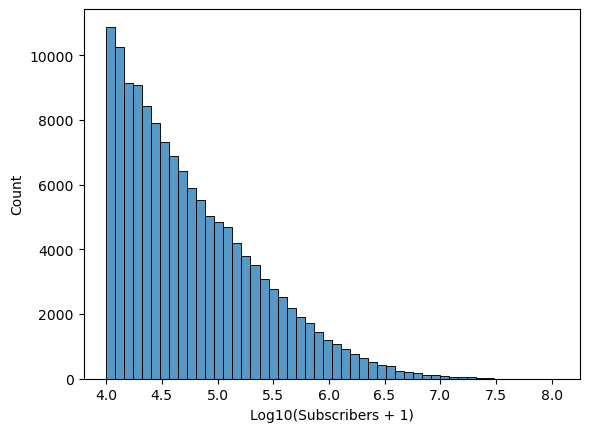

count    767979.000000
mean          3.902274
std           2.659866
min           1.098614
25%           2.097763
50%           3.134989
75%           4.850481
max          49.765779
Name: score, dtype: float64

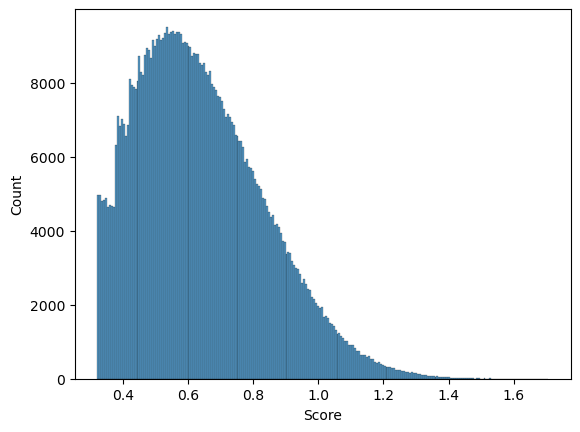

In [2]:
display(df_channels['subscribers_cc'].describe())
sns.histplot(np.log10(df_channels['subscribers_cc'] + 1), bins=50)
plt.xlabel("Log10(Subscribers + 1)")
plt.show()
display(df_scores['score'].describe())
sns.histplot(np.log10(df_scores['score'] + 1))
plt.xlabel("Score")
plt.show()

Here we aggregate groups's scores for each channel, for example :

score of 'Cannel1|Gaming' is 23,

score of 'Cannel1|Entertainment' is 12,

and there is no other group for Channel1, then it gets a 'total' score of 23+12 = 35.

In [ ]:
# 1. Extract just the channel names from both columns
# We use split to separate "Category" from "Channel"
ch1 = df_scores['group1'].str.split('|', n=1).str[1]
ch2 = df_scores['group2'].str.split('|', n=1).str[1]

# 2. Create two temporary DataFrames:
# One mapping Channel 1 -> Score
# One mapping Channel 2 -> Score
df_part1 = pd.DataFrame({'channel': ch1, 'score': df_scores['score']})
df_part2 = pd.DataFrame({'channel': ch2, 'score': df_scores['score']})

# 3. Concatenate them into one long list of (channel, score)
# This ensures that if "PewDiePie" is in group1 in row A and group2 in row B, both scores are captured.
df_combined = pd.concat([df_part1, df_part2])

# 4. Group by channel and sum the scores
total_scores = df_combined.groupby('channel')['score'].sum().reset_index()

# 5. Sort by score descending to see the most influential channels
total_scores = total_scores.sort_values(by='score', ascending=False).reset_index(drop=True)

print(f"Aggregated scores for {len(total_scores)} unique channels.")
print(total_scores.head())

✅ Aggregated scores for 45458 unique channels.
            channel        score
0           Insider  3462.025230
1   Great Big Story  3296.121071
2  Talking Nonsense  3135.384382
3          Grandayy  2797.091234
4               TED  2782.301316


### 4.3. Check for duplicate channels

In case of duplicate channel names, keep only the one with highest subscribers count

In [ ]:
# 1. Sort by subscribers descending (so the biggest channel is at the top)
#    We use 'subscribers_cc' as the authority metric for which duplicate to keep.
df_channels_clean = df_channels.sort_values(by='subscribers_cc', ascending=False)

# 2. Drop duplicates, keeping only the top one (the one with the most subs)
#    We also drop any rows where the name is NaN (you had 'nan' in your list)
df_channels_clean = df_channels_clean.dropna(subset=['name_cc'])
df_channels_clean = df_channels_clean.drop_duplicates(subset=['name_cc'], keep='first')

# 3. Verify
print(f"Original size: {df_channels.shape}")
print(f"Cleaned size:  {df_channels_clean.shape}")

# 4. Now merge this clean version with your scores
df_final = pd.merge(
    total_scores, 
    df_channels_clean[['name_cc', 'subscribers_cc']], 
    left_on='channel', 
    right_on='name_cc', 
    how='inner'
)


print(f"Final DataFrame ready with {len(df_final)} unique channels.")

Original size: (136470, 8)
Cleaned size:  (135691, 8)
✅ Final DataFrame ready with 45457 unique channels.


### 4.4. Run the OLS Analysis

Use statsmodels.OLS to predict log(score) from log(subscribers). 

We then print the summary, alongside with a scatter plot and the corresponding regression line.

                            OLS Regression Results                            
Dep. Variable:              log_score   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     2163.
Date:                Fri, 19 Dec 2025   Prob (F-statistic):               0.00
Time:                        11:31:33   Log-Likelihood:                -71616.
No. Observations:               45457   AIC:                         1.432e+05
Df Residuals:                   45455   BIC:                         1.433e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3026      0.044     52.805      0.0

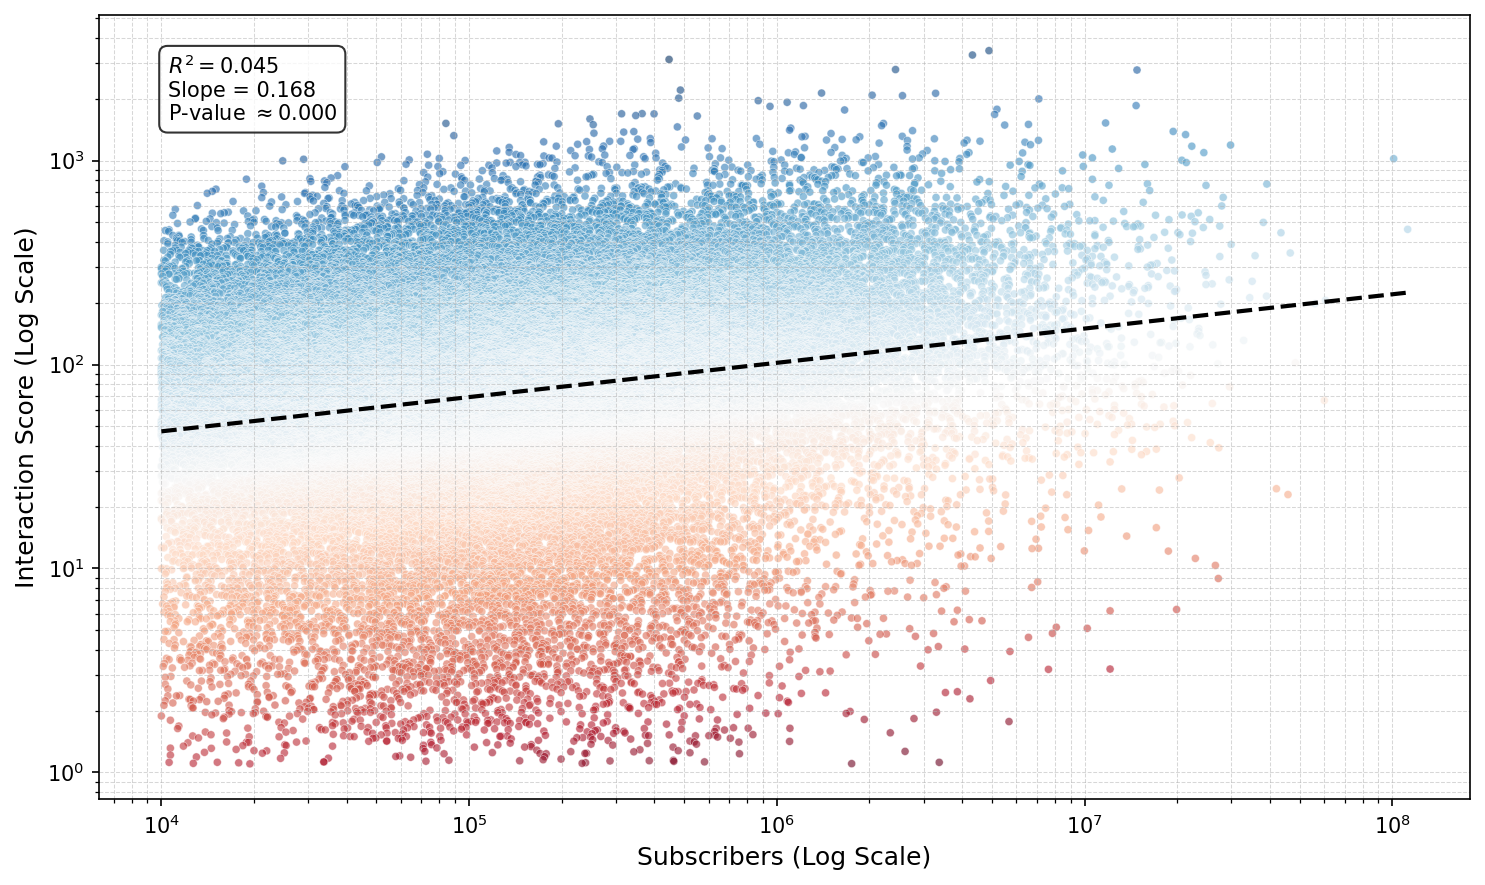

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm

# --- Data Prep ---
df_plot = df_final[(df_final['subscribers_cc'] > 0) & (df_final['score'] > 0)].copy()
df_plot['log_subs'] = np.log(df_plot['subscribers_cc'])
df_plot['log_score'] = np.log(df_plot['score'])

# Run Statsmodels OLS
X = sm.add_constant(df_plot['log_subs'])
model = sm.OLS(df_plot['log_score'], X).fit()
print(model.summary())

# Calculate Residuals
df_plot['residual'] = model.resid

# --- Plotting ---
plt.figure(figsize=(10, 6), dpi=150)

# 1. Scatter
sns.scatterplot(
    data=df_plot,
    x='subscribers_cc',
    y='score',
    hue='residual',
    palette='RdBu',
    alpha=0.6,
    s=15,
    legend=False
)

# 2. Regression Line
x_range = np.linspace(df_plot['subscribers_cc'].min(), df_plot['subscribers_cc'].max(), 100)
y_pred = np.exp(model.params['const'] + model.params['log_subs'] * np.log(x_range))
plt.plot(x_range, y_pred, color='black', linestyle='--', linewidth=2, label='Trend')

# 3. Formatting
plt.xscale('log')
plt.yscale('log')
# plt.title('Channel Authority vs. Audience Size', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Subscribers (Log Scale)', fontsize=12)
plt.ylabel('Interaction Score (Log Scale)', fontsize=12)
plt.grid(True, which="both", ls="--", linewidth=0.5, alpha=0.5)

stats_text = (
    f"$R^2 = {model.rsquared:.3f}$\n"
    f"Slope = {model.params['log_subs']:.3f}\n"
    r"P-value $\approx 0.000$" 
)

plt.gca().text(
    0.05, 0.95, stats_text, 
    transform=plt.gca().transAxes, 
    verticalalignment='top',
    bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="black", alpha=0.8)
)

plt.tight_layout()
plt.show()